In [1]:
import findspark
findspark.init('E:\spark')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('DataMining').getOrCreate()

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.classification import LogisticRegression,DecisionTreeClassifier,RandomForestClassifier,NaiveBayes,MultilayerPerceptronClassifier
from pyspark.ml.classification import DecisionTreeClassifier,GBTClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score
from pyspark.sql import SparkSession
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, ChiSqSelector, OneHotEncoder
from pyspark.ml.regression import RandomForestRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import when, log10
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [6]:
# Importing data which has a header. Schema is automatically configured.
la_traffic_df = spark.read.csv('LA_Accidents_preprocessed.csv', header=True, inferSchema=True)
# Let's see the data. You'll notice nulls.
la_traffic_df.head()
# One hot encoding
la_traffic_pd = la_traffic_df.toPandas()

# feature encoding 
encoded_df = la_traffic_pd.copy()
encoded_df['Severity_encoded'] = encoded_df['Severity'].astype(int)
encoded_df
encoded_df = encoded_df.drop("Severity",axis=1)

In [7]:
encoded_df = pd.get_dummies(encoded_df, columns=[
    "Wind_Direction", "Weather_Condition","Sunrise_Sunset",
    "Civil_Twilight","Nautical_Twilight","Astronomical_Twilight"])

# encoded_df['Distance(mi)'] = encoded_df['Distance(mi)'].apply(
#     lambda x: x if x > 0 else 0.003)
# encoded_df['log_Distance(mi)'] = np.log10(encoded_df['Distance(mi)'])

columns = encoded_df.columns.tolist()

In [8]:
# Select relevant columns
import copy

la_traffic_df = spark.createDataFrame(encoded_df)
# columns.pop("Severity_encoded")
selected_columns = copy.deepcopy(columns)
selected_columns.remove("Severity_encoded")

# Assemble feature vectors
assembler = VectorAssembler(inputCols=selected_columns, outputCol="features",handleInvalid="keep")
la_traffic_df = assembler.transform(la_traffic_df)

# Perform feature selection using ChiSqSelector
selector = ChiSqSelector(numTopFeatures=60,featuresCol="features", outputCol="selected_features", labelCol="Severity_encoded")
model = selector.fit(la_traffic_df)
la_traffic_df = model.transform(la_traffic_df)

# show the name of selected features
selected_features = model.selectedFeatures
selected_feature_names = [selected_columns[i] for i in selected_features]
print("Selected Feature Names:", selected_feature_names)

Selected Feature Names: ['Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'Railway', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Distance(mi)', 'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Weekday', 'Hour', 'Wind_Direction_CALM', 'Wind_Direction_E', 'Wind_Direction_ENE', 'Wind_Direction_N', 'Wind_Direction_NE', 'Wind_Direction_NNE', 'Wind_Direction_NW', 'Wind_Direction_S', 'Wind_Direction_SSE', 'Wind_Direction_SSW', 'Wind_Direction_SW', 'Wind_Direction_V', 'Wind_Direction_VAR', 'Wind_Direction_W', 'Wind_Direction_WNW', 'Wind_Direction_WSW', 'Weather_Condition_Clear', 'Weather_Condition_Cloudy', 'Weather_Condition_Fair', 'Weather_Condition_Fair / Windy', 'Weather_Condition_Fog', 'Weather_Condition_Haze', 'Weather_Condition_Heavy Rain', 'Weather_Condition_Light Rain', 'Weather_Condition_Mostly Cloudy', 'Weather_Condition_Overcast', 'Weather_Condition_Partly Cloudy', 'Weather_Condition_Partl

In [12]:
# Split the data into training and test sets
(trainingData, testData, valData) = la_traffic_df.randomSplit([0.8, 0.1,0.1])

params_dic={"maxDepth":[5,8,10,15,20], "minInstancesPerNode":[1,2,3,4], "impurity":['entropy', 'gini']}

params_combination = []
for depth in params_dic["maxDepth"]:
    for instance in params_dic["minInstancesPerNode"]:
        for impurity in params_dic["impurity"]:
            params_combination.append([depth,instance,impurity])
            
for params in params_combination:
    # Create a DecisionTreeClassifier
    print("********************************************************************")
    print(params)
    dt = DecisionTreeClassifier(featuresCol="selected_features", labelCol="Severity_encoded",maxDepth=params[0], minInstancesPerNode=params[1], impurity=params[2])

    # Create a pipeline
    pipeline = Pipeline(stages=[dt])

    # Train the Decision Tree model
    dt_model = pipeline.fit(trainingData)

    # Make predictions on the test data
    val_predictions = dt_model.transform(valData)
    train_predictions = dt_model.transform(trainingData)

    # Evaluate the model on the training data
    train_evaluator = MulticlassClassificationEvaluator(labelCol="Severity_encoded", predictionCol="prediction", metricName="accuracy")
    train_accuracy = train_evaluator.evaluate(train_predictions)
    print(f"Training set accuracy = {train_accuracy}")

    # Evaluate the model on the val data
    val_evaluator = MulticlassClassificationEvaluator(labelCol="Severity_encoded", predictionCol="prediction", metricName="accuracy")
    val_accuracy = val_evaluator.evaluate(val_predictions)
    print(f"Val set accuracy = {val_accuracy}")

    # Print the confusion matrix on training set
    train_confusion_matrix = train_predictions.crosstab("Severity_encoded", "prediction")
    train_confusion_matrix.show()

    # Print the confusion matrix on test set
    val_confusion_matrix = val_predictions.crosstab("Severity_encoded", "prediction")
    val_confusion_matrix.show()

********************************************************************
[5, 1, 'entropy']
Training set accuracy = 0.8132267441860465
Val set accuracy = 0.8072126510671124
+---------------------------+-----+-----+
|Severity_encoded_prediction|  2.0|  3.0|
+---------------------------+-----+-----+
|                          1|  202|   10|
|                          3|12745|15243|
|                          4|  706|   31|
|                          2|86586| 9693|
+---------------------------+-----+-----+

+---------------------------+-----+----+
|Severity_encoded_prediction|  2.0| 3.0|
+---------------------------+-----+----+
|                          3| 1607|1820|
|                          4|  100|   6|
|                          1|   27|   0|
|                          2|10737|1259|
+---------------------------+-----+----+

********************************************************************
[5, 1, 'gini']
Training set accuracy = 0.8132427165857399
Val set accuracy = 0.8070840833119054
+

Training set accuracy = 0.8166368515205724
Val set accuracy = 0.8098482900488557
+---------------------------+-----+-----+---+
|Severity_encoded_prediction|  2.0|  3.0|4.0|
+---------------------------+-----+-----+---+
|                          1|  195|   17|  0|
|                          3|11722|16264|  2|
|                          4|  644|   79| 14|
|                          2|85978|10293|  8|
+---------------------------+-----+-----+---+

+---------------------------+-----+----+---+
|Severity_encoded_prediction|  2.0| 3.0|4.0|
+---------------------------+-----+----+---+
|                          3| 1488|1939|  0|
|                          4|   95|  10|  1|
|                          1|   26|   1|  0|
|                          2|10658|1335|  3|
+---------------------------+-----+----+---+

********************************************************************
[8, 2, 'gini']
Training set accuracy = 0.8174913749041656
Val set accuracy = 0.8092054512728207
+-----------------------

Training set accuracy = 0.8222910810120112
Val set accuracy = 0.8109411159681152
+---------------------------+---+-----+-----+---+
|Severity_encoded_prediction|1.0|  2.0|  3.0|4.0|
+---------------------------+---+-----+-----+---+
|                          1| 11|  187|   14|  0|
|                          3|  1|11593|16364| 30|
|                          4|  0|  571|   72| 94|
|                          2|  3|86495| 9757| 24|
+---------------------------+---+-----+-----+---+

+---------------------------+---+-----+----+---+
|Severity_encoded_prediction|1.0|  2.0| 3.0|4.0|
+---------------------------+---+-----+----+---+
|                          3|  0| 1494|1928|  5|
|                          4|  0|   86|  14|  6|
|                          1|  0|   26|   1|  0|
|                          2|  1|10681|1306|  8|
+---------------------------+---+-----+----+---+

********************************************************************
[10, 3, 'entropy']


ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "E:\spark\python\lib\py4j-0.10.9.3-src.zip\py4j\java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "E:\spark\python\lib\py4j-0.10.9.3-src.zip\py4j\clientserver.py", line 475, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "E:\anaconda\envs\python39\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: 

In [13]:
# Split the data into training and test sets
(trainingData, testData, valData) = la_traffic_df.randomSplit([0.8, 0.1,0.1])

params_dic={"maxDepth":[10,15,20], "minInstancesPerNode":[1,2,3,4], "impurity":['entropy', 'gini']}

params_combination = []
for depth in params_dic["maxDepth"]:
    for instance in params_dic["minInstancesPerNode"]:
        for impurity in params_dic["impurity"]:
            params_combination.append([depth,instance,impurity])
            
for params in params_combination:
    # Create a DecisionTreeClassifier
    print("********************************************************************")
    print(params)
    dt = DecisionTreeClassifier(featuresCol="selected_features", labelCol="Severity_encoded",maxDepth=params[0], minInstancesPerNode=params[1], impurity=params[2])

    # Create a pipeline
    pipeline = Pipeline(stages=[dt])

    # Train the Decision Tree model
    dt_model = pipeline.fit(trainingData)

    # Make predictions on the test data
    val_predictions = dt_model.transform(valData)
    train_predictions = dt_model.transform(trainingData)

    # Evaluate the model on the training data
    train_evaluator = MulticlassClassificationEvaluator(labelCol="Severity_encoded", predictionCol="prediction", metricName="accuracy")
    train_accuracy = train_evaluator.evaluate(train_predictions)
    print(f"Training set accuracy = {train_accuracy}")

    # Evaluate the model on the val data
    val_evaluator = MulticlassClassificationEvaluator(labelCol="Severity_encoded", predictionCol="prediction", metricName="accuracy")
    val_accuracy = val_evaluator.evaluate(val_predictions)
    print(f"Val set accuracy = {val_accuracy}")

    # Print the confusion matrix on training set
    train_confusion_matrix = train_predictions.crosstab("Severity_encoded", "prediction")
    train_confusion_matrix.show()

    # Print the confusion matrix on test set
    val_confusion_matrix = val_predictions.crosstab("Severity_encoded", "prediction")
    val_confusion_matrix.show()

********************************************************************
[10, 1, 'entropy']
Training set accuracy = 0.822841906100063
Val set accuracy = 0.8147055049403311
+---------------------------+---+-----+-----+---+
|Severity_encoded_prediction|1.0|  2.0|  3.0|4.0|
+---------------------------+---+-----+-----+---+
|                          1|  8|  180|   28|  0|
|                          3|  1|10798|17120|  6|
|                          4|  0|  604|   86| 68|
|                          2|  0|85874|10479|  9|
+---------------------------+---+-----+-----+---+

+---------------------------+---+-----+----+---+
|Severity_encoded_prediction|1.0|  2.0| 3.0|4.0|
+---------------------------+---+-----+----+---+
|                          1|  0|   20|   3|  0|
|                          3|  0| 1419|2103|  4|
|                          4|  0|   68|  12|  4|
|                          2|  1|10591|1357|  4|
+---------------------------+---+-----+----+---+

**************************************

+---------------------------+---+-----+----+---+
|Severity_encoded_prediction|1.0|  2.0| 3.0|4.0|
+---------------------------+---+-----+----+---+
|                          1|  0|   19|   4|  0|
|                          3|  3| 1388|2124| 11|
|                          4|  0|   63|  13|  8|
|                          2|  8|10495|1422| 28|
+---------------------------+---+-----+----+---+

********************************************************************
[15, 1, 'gini']
Training set accuracy = 0.8456023822259123
Val set accuracy = 0.8106634158860516
+---------------------------+---+-----+-----+---+
|Severity_encoded_prediction|1.0|  2.0|  3.0|4.0|
+---------------------------+---+-----+-----+---+
|                          1| 49|  140|   27|  0|
|                          3|  5| 8925|18990|  5|
|                          4|  0|  397|   52|309|
|                          2| 10|86573| 9773|  6|
+---------------------------+---+-----+-----+---+

+---------------------------+---+-----+-

Val set accuracy = 0.8017451559091492
+---------------------------+---+-----+-----+---+
|Severity_encoded_prediction|1.0|  2.0|  3.0|4.0|
+---------------------------+---+-----+-----+---+
|                          1|114|   86|   16|  0|
|                          3|  4| 8163|19757|  1|
|                          4|  0|  236|   30|492|
|                          2|  3|89671| 6684|  4|
+---------------------------+---+-----+-----+---+

+---------------------------+---+-----+----+---+
|Severity_encoded_prediction|1.0|  2.0| 3.0|4.0|
+---------------------------+---+-----+----+---+
|                          1|  2|   15|   6|  0|
|                          3|  1| 1575|1932| 18|
|                          2|  9|10546|1359| 39|
|                          4|  0|   51|  17| 16|
+---------------------------+---+-----+----+---+

********************************************************************
[20, 2, 'entropy']
Training set accuracy = 0.8639640430780531
Val set accuracy = 0.8020017964840241

In [ ]:
# Split the data into training and test sets
(trainingData, testData) = la_traffic_df.randomSplit([0.9, 0.1])

dt = DecisionTreeClassifier(featuresCol="selected_features", labelCol="Severity_encoded",maxDepth=10, minInstancesPerNode=4, impurity='gini')

# Create a pipeline
pipeline = Pipeline(stages=[dt])

# Train the Decision Tree model
dt_model = pipeline.fit(trainingData)

# Make predictions on the test data
test_predictions = dt_model.transform(testData)
train_predictions = dt_model.transform(trainingData)


In [17]:

# Evaluate the model on the training data
train_evaluator = MulticlassClassificationEvaluator(labelCol="Severity_encoded", predictionCol="prediction", metricName="accuracy")
train_accuracy = train_evaluator.evaluate(train_predictions)
print(f"Training set accuracy = {train_accuracy}")

# Evaluate the model on the val data
test_evaluator = MulticlassClassificationEvaluator(labelCol="Severity_encoded", predictionCol="prediction", metricName="accuracy")
test_accuracy = test_evaluator.evaluate(test_predictions)
print(f"Test set accuracy = {test_accuracy}")

# Print the confusion matrix on training set
train_confusion_matrix = train_predictions.crosstab("Severity_encoded", "prediction")
train_confusion_matrix.show()

# Print the confusion matrix on test set
test_confusion_matrix = test_predictions.crosstab("Severity_encoded", "prediction")
test_confusion_matrix.show()

Training set accuracy = 0.8214049909481381
Test set accuracy = 0.8190074187771809
+---------------------------+---+-----+-----+---+
|Severity_encoded_prediction|1.0|  2.0|  3.0|4.0|
+---------------------------+---+-----+-----+---+
|                          1| 13|  184|   30|  0|
|                          3|  0|12254|19186| 20|
|                          2| 12|96443|11845| 26|
|                          4|  0|  636|  149| 57|
+---------------------------+---+-----+-----+---+

+---------------------------+---+-----+----+---+
|Severity_encoded_prediction|1.0|  2.0| 3.0|4.0|
+---------------------------+---+-----+----+---+
|                          1|  0|   28|   2|  0|
|                          3|  0| 1371|2093|  3|
|                          4|  0|   74|  18|  5|
|                          2|  8|10708|1324|  2|
+---------------------------+---+-----+----+---+



In [30]:
feature_importances = dt_model.stages[0].featureImportances

# Create a DataFrame to show the feature names and their importances
feature_names = la_traffic_df.columns  # Assuming la_traffic_df contains your dataset
feature_importance_df = spark.createDataFrame(list(zip(selected_feature_names, feature_importances.toArray().tolist())), ["Feature", "Importance"])





# Display the feature importances
# feature_importance_df.show()
sorted_feature_importance_df = feature_importance_df.orderBy(feature_importance_df["Importance"].desc()).limit(20)
# Display the sorted feature importances
sorted_feature_importance_df.show()





+--------------------+--------------------+
|             Feature|          Importance|
+--------------------+--------------------+
|        Distance(mi)|  0.5283117113413829|
|   Precipitation(in)|  0.1524740223164315|
|      Traffic_Signal| 0.11199584709467687|
|                Stop| 0.02518430400141972|
|       Wind_Chill(F)| 0.02359578074617149|
|   Wind_Direction_SW| 0.01594615078069396|
|         Humidity(%)|0.014887050369357752|
|             Weekday|0.014758294322569046|
|            Crossing|0.014622765206290975|
|     Wind_Speed(mph)|0.010940367363092016|
|            Junction| 0.01025323220058572|
|Nautical_Twilight...|0.009701565256290096|
|                Hour|0.009642274817030868|
|             Railway|0.009403746723784747|
|             Station|0.008149569401116885|
|  Wind_Direction_SSW|0.007257824704193809|
|  Wind_Direction_WSW|0.007062970137568073|
|        Pressure(in)| 0.00572811271311177|
|Weather_Condition...|0.004627924867344401|
|      Temperature(F)|0.00368043

Exception ignored in: <function JavaWrapper.__del__ at 0x000001B1F2FF7160>
Traceback (most recent call last):
  File "E:\spark\python\pyspark\ml\wrapper.py", line 39, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'DecisionTreeClassifier' object has no attribute '_java_obj'


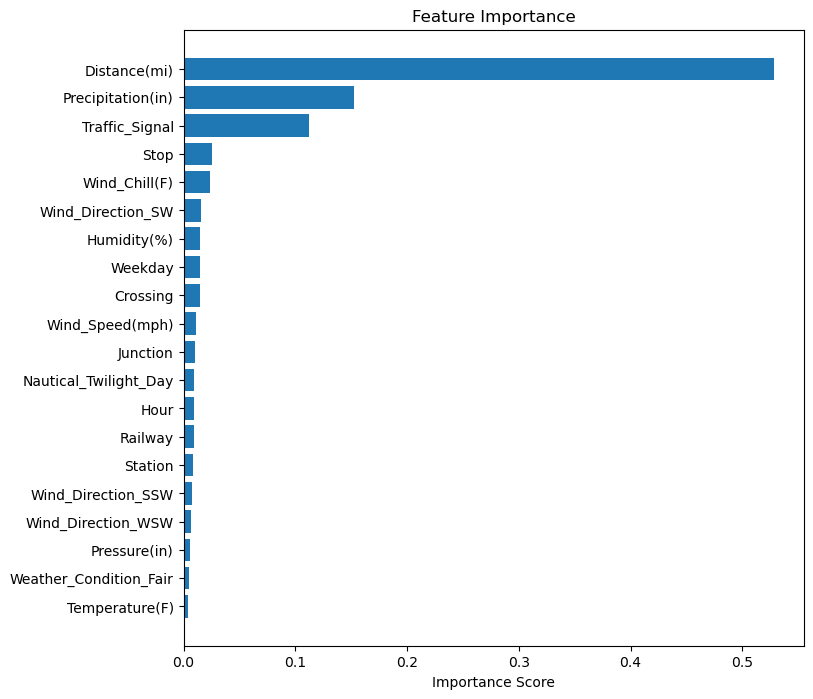

In [31]:

import matplotlib.pyplot as plt

# Extract feature names and importance scores
feature_names = sorted_feature_importance_df.select("feature").rdd.flatMap(lambda x: x).collect()
importance_scores = sorted_feature_importance_df.select("importance").rdd.flatMap(lambda x: x).collect()

# Sort feature names and importance scores by importance scores in descending order
sorted_feature_names = [name for _, name in sorted(zip(importance_scores, feature_names), reverse=False)]
sorted_importance_scores = sorted(importance_scores, reverse=False)

# Create a bar plot
plt.figure(figsize=(8, 8))
plt.barh(range(len(sorted_feature_names)), sorted_importance_scores, align='center')
plt.yticks(range(len(sorted_feature_names)), sorted_feature_names)
plt.xlabel('Importance Score')
plt.title('Feature Importance')

# Show the plot
plt.show()


In [42]:
param_map = dt_model.stages[-1].extractParamMap()
# print(param_map)
for key in param_map:
    print(key, ": ",param_map[key] )

DecisionTreeClassifier_0709718dc24e__cacheNodeIds :  False
DecisionTreeClassifier_0709718dc24e__checkpointInterval :  10
DecisionTreeClassifier_0709718dc24e__featuresCol :  selected_features
DecisionTreeClassifier_0709718dc24e__impurity :  gini
DecisionTreeClassifier_0709718dc24e__labelCol :  Severity_encoded
DecisionTreeClassifier_0709718dc24e__leafCol :  
DecisionTreeClassifier_0709718dc24e__maxBins :  32
DecisionTreeClassifier_0709718dc24e__maxDepth :  10
DecisionTreeClassifier_0709718dc24e__maxMemoryInMB :  256
DecisionTreeClassifier_0709718dc24e__minInfoGain :  0.0
DecisionTreeClassifier_0709718dc24e__minInstancesPerNode :  4
DecisionTreeClassifier_0709718dc24e__minWeightFractionPerNode :  0.0
DecisionTreeClassifier_0709718dc24e__predictionCol :  prediction
DecisionTreeClassifier_0709718dc24e__probabilityCol :  probability
DecisionTreeClassifier_0709718dc24e__rawPredictionCol :  rawPrediction
DecisionTreeClassifier_0709718dc24e__seed :  3004434143589667907


In [38]:
test_predictions.select("selected_features","rawPrediction","probability","prediction").show()

+--------------------+--------------------+--------------------+----------+
|   selected_features|       rawPrediction|         probability|prediction|
+--------------------+--------------------+--------------------+----------+
|(60,[11,12,13,14,...|[0.0,8.0,9614.0,1...|[0.0,3.5693570695...|       3.0|
|(60,[11,12,13,14,...|[0.0,8.0,9614.0,1...|[0.0,3.5693570695...|       3.0|
|(60,[11,12,13,14,...|[0.0,8.0,9614.0,1...|[0.0,3.5693570695...|       3.0|
|(60,[11,12,13,14,...|[0.0,8.0,9614.0,1...|[0.0,3.5693570695...|       3.0|
|(60,[11,12,13,14,...|[0.0,8.0,9614.0,1...|[0.0,3.5693570695...|       3.0|
|(60,[11,12,13,14,...|[0.0,8.0,9614.0,1...|[0.0,3.5693570695...|       3.0|
|(60,[11,12,13,14,...|[0.0,8.0,9614.0,1...|[0.0,3.5693570695...|       3.0|
|(60,[11,12,13,14,...|[0.0,8.0,9614.0,1...|[0.0,3.5693570695...|       3.0|
|(60,[11,12,13,14,...|[0.0,8.0,9614.0,1...|[0.0,3.5693570695...|       3.0|
|(60,[11,12,13,14,...|[0.0,8.0,9614.0,1...|[0.0,3.5693570695...|       3.0|
|(60,[11,12,